In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import requests
import time

# Homework 2 - Pixels and Filtering

In [17]:
# helper functions

image_link = "https://i.etsystatic.com/16952472/r/il/bf0677/1530154159/il_fullxfull.1530154159_97sx.jpg"

# We will be using a kernel that gives us an outline kernel. An outline kernel (also called an "edge" kernel) is used to highlight large differences in pixel values
kernel = np.array([[-1, -1, -1], 
                   [-1, 8, -1], 
                   [-1, -1, -1]])


def download_image(image_link: str) -> str:
    # Download the image and save it locally as a .jpg file
    response = requests.get(image_link)
    local_filename = "downloaded_image.jpg"
    with open(local_filename, "wb") as f:
        f.write(response.content)
    return local_filename


def apply_custom_kernel(image_path: str, kernel: np.ndarray) -> np.ndarray:
    """
    Apply a custom kernel to an image using OpenCV.

    Args:
        image_path (str): Path to the input image.
        kernel (np.ndarray): Custom kernel to be applied.

    Returns:
        np.ndarray: Filtered image after applying the custom kernel.
    """
    # Read the image
    image = cv2.imread(image_path)

    # Convert to grayscale if the image is color
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply the custom kernel
    filtered_image = cv2.filter2D(image, -1, kernel)

    return filtered_image


## Exercise 1

1. Complete the function `exercise_1` to apply a kernel to an image.
2. Compare (time, correctness) of your function with the same function implemented in OpenCV (see helper function `apply_custom_kernel`).


In [3]:
def exercise_1(image_path: str, kernel: np.ndarray) -> np.ndarray:
    """
    1. Read the image
    2. Convert the image to grayscale
    3. Apply the kernel to the image
        - use the sliding window principle from the lecture
        - if you want you can make it very efficient, but in principle two for loops (one over the image height and one over the image width should suffice)
    4. The main challenge is to handle the border pixels. Convolution is a sliding window operation, so the window needs to be completely inside the image.
        Decide how to handle edge cases, be creative!
    5. Return the filtered image (should have the same dimensions as the input image). 
        - make sure that the final grayscale image has pixel values between 0 and 255.
        - make sure that the dtype of the final image is uint8 
    """
    # Read the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # it is needed as intermediary computation can be out of bounds for uint8
    image = image.astype(np.float32)
    # the edges are filled with 0s.
    # advantages: simple to implement, clear separation of image boundaries
    # disadvantages: artificial dark edges, may affect the edge detection
    output = np.zeros_like(image, dtype=np.float32)

    offset_x = kernel.shape[0] // 2
    offset_y = kernel.shape[1] // 2

    for x in range(offset_x, image.shape[0] - offset_x):
        for y in range(offset_y, image.shape[1] - offset_y):
            output[x, y] = np.sum(image[x-offset_x:x+offset_x+1, y-offset_y:y+offset_y+1] * kernel)

    # Convert back to uint8
    output = np.clip(output, 0, 255).astype(np.uint8)

    # </your_code_here>

    assert image.shape == output.shape

    return output


The manual implementation of the convolution kernel took 7.863 seconds vs 0.016 seconds.
Why is that so? Edit the markdown cell below and write your answer!


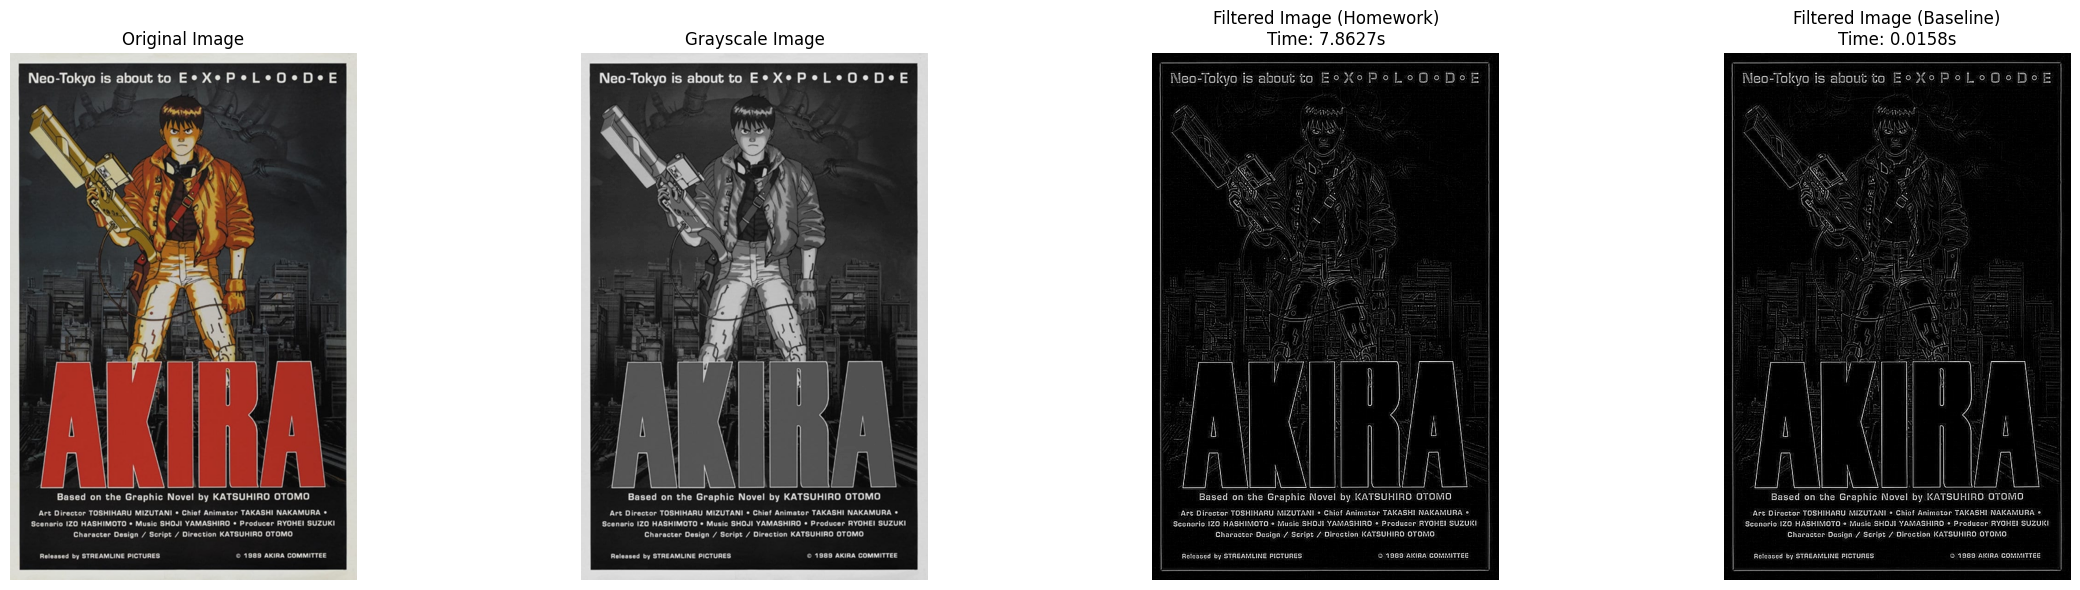

In [19]:
# Apply your custom kernel
image_path = download_image(image_link)
start_time = time.time()
filtered_image = exercise_1(image_path, kernel)
execution_time_homework = time.time() - start_time

# Apply the OpenCV implementation of the same kernel
start_time = time.time()
filtered_image_baseline = apply_custom_kernel(image_path, kernel)
execution_time_baseline = time.time() - start_time

print(
    f"The manual implementation of the convolution kernel took {execution_time_homework:.3f} seconds vs {execution_time_baseline:.3f} seconds.\n"
    "Why is that so? Edit the markdown cell below and write your answer!"
)

# Display the original, grayscale, filtered, and custom filtered images
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 6))

# Original image
original_image = cv2.imread(image_path)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
ax1.imshow(original_image)
ax1.axis("off")
ax1.set_title("Original Image")

# Grayscale image
grayscale_image = cv2.cvtColor(original_image, cv2.COLOR_RGB2GRAY)
ax2.imshow(grayscale_image, cmap="gray")
ax2.axis("off")
ax2.set_title("Grayscale Image")

# Filtered image (homework)
ax3.imshow(filtered_image, cmap="gray")
ax3.axis("off")
ax3.set_title(f"Filtered Image (Homework)\nTime: {execution_time_homework:.4f}s")

# Filtered image (baseline)
ax4.imshow(filtered_image_baseline, cmap="gray")
ax4.axis("off")
ax4.set_title(f"Filtered Image (Baseline)\nTime: {execution_time_baseline:.4f}s")

plt.tight_layout()
plt.show()

Your answer:

The manual implementation of the convolution kernel took longer because it is not optimized for performance.
OpenCV uses CPU's SIMD instructions to process multiple pixels at once, all in compiled C++ code and no one pixel at a time, no python overhead for memory access.